In [ ]:
import os
os.chdir("/root/jupyter_workspace/ml_demo/")     # 替换成自己的目录
print(os.getcwd())

# 加载数据集
train_set,valid_set与test_set分别是训练集，验证集和测试集，以tuple的形式组织(x,y)，x代表样本，y代表样本标签

In [3]:
def load_data():
    f = gzip.open("mnist.pkl.gz", "rb")
    train_set, valid_set, test_set = pickle.load(f, encoding="latin1")
    f.close()
    return [train_set, valid_set, test_set]

# 定义损失函数
多分类问题，采用**负对数似然函数**作为损失函数。p_y_given_x是模型的预测，是一个m\*10的二维数组，每一行代表一个样本，每一列代表模型预测样本是0~9的概率。np.arange(y.shape[0])是一个一维数组，包含[0,1,$\dots$,m-1]，y是样本对应的真实标签，是一个一维数组。p_y_given_x[[0,1,$\dots$,m-1][y[0],y[1],$\dots$,y[m-1]]]等价于p_y_given_x[0,y[0]]，p_y_given_x[1,y[1]]，$\dots$，p_y_given_x[m-1,y[m-1]]，即取出每个样本真实类别对应的模型预测值，我们希望这个值越大越好。

$$
C=-\log y_r
$$

$$
y_r=\frac{e^{z_r}}{\sum_ke^{z_k}}
$$

求导

**1、i=r**

$$
\frac{\partial C}{\partial z_r}=\frac{\partial C}{\partial y_r}\frac{\partial y_r}{\partial z_r}=-\frac{1}{y_r}(\frac{e^{z_r}}{\sum_ke^{z_k}}-e^{z_r}\frac{e^{z_r}}{(\sum_ke^{z_k})^2})=-\frac{1}{y_r}(y_r-y_r^2)=y_r-1
$$

**2、i != r**

$$
\frac{\partial C}{\partial z_i}=\frac{\partial C}{\partial y_r}\frac{\partial y_r}{\partial z_i}=-\frac{1}{y_r}(-e^{z_r}\frac{e^{z_i}}{(\sum_ke^{z_k})^2})=-\frac{1}{y_r}(-y_ry_r)=y_i-0
$$

统一起来，有
$$
\frac{\partial C}{\partial z_i}=y_i - \hat{y}_i
$$

In [4]:
# 定义损失函数
def negative_log_likehood(p_y_given_x, y):
    return -np.mean(np.log(p_y_given_x)[np.arange(y.shape[0]), y])

# 统计错误样本数目
首先需要根据网络的预测概率，选择概率最大的作为网络预测标签

In [5]:
# 得到每个样本的预测标签
def pred_lable(p_y_given_x):
    y_pred = []
    for i in range(p_y_given_x.shape[0]):
        max_index = np.argwhere(p_y_given_x[i] == np.max(p_y_given_x[i]))
        y_pred.append(max_index[0,0])
    # print(y_pred[:50])
    return np.array(y_pred)

错误样本数能直观展示模型性能

In [6]:
# 统计预测错误样本数目
def error(y_pred, y):
    # print(y[:50])
    return np.sum((y_pred == y) == False)

# 构造样本真实标签矩阵
原始数据集中，每个样本的标签对应的是一个标量，直接指示样本是哪个数字。但在计算梯度中，需要将y扩充成与模型输出维度相同的向量。

In [7]:
# 构造样本真实标签矩阵
def getTruthmatrix(y):
    matrix = np.zeros((len(y), 10))
    for i in np.arange(len(y)):
        matrix[i, y[i]] = 1
    return matrix

# sigmoid函数以及其导数

In [8]:
# Sigmoid函数
def sigmoid(x):
    return 1.0 / (1 + np.exp(-x))

In [9]:
# Sigmoid函数的导数
def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

# 初始化权重w
确定了隐含层数目、隐含层神经元数目，并初始化连接权重，神经网络模型就确定了

In [10]:
def hiddenLayer(n_input, n_output, hidden_unit, rand):
    W = []
    try:
        if len(hidden_unit) == 1:
            w_0 = np.asarray(rand.uniform(low=-np.sqrt(6. / (n_input + hidden_unit[0])), 
                                          high=np.sqrt(6. / (n_input + hidden_unit[0])), 
                                          size=(n_input, hidden_unit[0])))
            w_0 *= 4
            W.append(w_0)
            w_1 = np.asarray(rand.uniform(low=-np.sqrt(6. / (hidden_unit[0] + n_output)), 
                                          high=np.sqrt(6. / (hidden_unit[0] + n_output)), 
                                          size=(hidden_unit[0], n_output)))
            w_1 *= 4
            W.append(w_1)
        else:
            w_0 = 4 * np.asarray(rand.uniform(low=-np.sqrt(6. / (n_input + hidden_unit[0])), 
                                              high=np.sqrt(6. / (n_input + hidden_unit[0])), 
                                              size=(n_input, hidden_unit[0])))
            W.append(w_0)
            for i in range(len(hidden_unit) - 1):
                W.append(4 * np.asarray(rand.uniform(low=-np.sqrt(6. / (hidden_unit[i] + hidden_unit[i + 1])), 
                                                     high=np.sqrt(6. / (hidden_unit[i] + hidden_unit[i + 1])), 
                                                     size=(hidden_unit[i], hidden_unit[i + 1])))
                        )
            W.append(4 * np.asarray(rand.uniform(low=-np.sqrt(6. / (hidden_unit[-1] + n_output)), 
                                                 high=np.sqrt(6. / (hidden_unit[-1] + n_output)), 
                                                 size=(hidden_unit[-1], n_output)))
                     )
    except:
        print("hidden_unit输入需要一个列表")
        pass
    
    return W

# 计算$|w|$的导数

In [12]:
def sign(w):
    # 计算|w|的导数，使用L1正则化时需要
    w = np.where(w > 0, 1, w)
    w = np.where(w >= 0, w, -1)
    
    return w

# 正向传播
正向传播，得到模型预测值

In [13]:
# 正向传播
def forward_porpagation(x, W):
    activations = [x]    # 用于存储每一层的输出
    zs = [x]    # 用于存储每一层的输入
    a = x
    # 隐藏层
    for i in range(len(W) - 1):
        z = np.dot(a, W[i])
        zs.append(z)
        a = sigmoid(z)
        activations.append(a)
    # 输出层
    z = np.dot(a, W[-1])
    e = np.exp(z)
    zs.append(z)
    p = (np.transpose(e) / np.sum(e, axis=1)).T
    activations.append(p)
    
    return (activations, zs)

# BP算法
采用BP算法，计算每一层连接$w$的梯度
因为
$$
\frac{\partial C}{\partial w_{ij}^l}=\frac{\partial C}{\partial z_j^l}\frac{\partial z_j^l}{\partial w_{ij}^l}
$$
关键是求$\frac{\partial C}{\partial z_j^l}$，令其等于$\delta_{j}^l$

**1、输出层**
$$
\frac{\partial C}{\partial z_j^L}=\frac{\partial C}{\partial y_j^L}\frac{\partial y_j^L}{\partial z_j^L}=\nabla C(y^L)*\delta '(z_j^L)
$$

**2、非输出层**
$$
\frac{\partial C}{\partial z_j^l}=\sum_k\frac{\partial C}{\partial z_k^{l+1}}\frac{\partial z_k^{l+1}}{\partial a_j^l}\frac{\partial a_j^l}{\partial z_j^l}=\sum_k \delta_k^{l+1}w_{jk}^{l+1}\delta '(z_j^l)
$$

In [14]:
# 反向传播算法
def backprop(activations, zs, w, y, L1_reg, L2_reg):
    grad_w = [np.zeros(weight.shape) for weight in w]
    # 反向传播
    delta = activations[-1] - y    # 最后一层, m*10
    grad_w[-1] = np.dot(np.transpose(activations[-2]), delta)
    for l in range(2, len(w) + 1):
        delta = np.dot(delta, w[-l+1].transpose()) * sigmoid_derivative(zs[-l])     # 其它层
        grad_w[-l] = np.dot(np.transpose(activations[-l-1]), delta) / y.shape[0] + L1_reg * sign(w[-l]) + L2_reg * w[-l]
        
    return grad_w

计算出梯度后，对$w$沿着梯度的反方向更新
$$
w^{n+1} = w^{n} - \alpha\nabla C(w^{n})
$$

In [15]:
# 每一次参数更新
def step_gradient(y_truth_matrix, w_current, activations, zs, alpha, L1_reg, L2_reg):
    if len(w_current) > 1:
        # 多层网络，采用反向传播计算梯度
        grad_w = backprop(activations, zs, w_current, y_truth_matrix, L1_reg, L2_reg)
        # 更新参数
        new_w = [w - nw * alpha for w, nw in zip(w_current, grad_w)]
    else:
        # 无隐含层，直接计算当前w对应的梯度
        new_w = []
        grad_w = np.dot(np.transpose(activations[-2]), activations[-1] - y_truth_matrix) / y_truth_matrix.shape[0]
        grad_w = grad_w + L1_reg * sign(w_current[-1]) + L2_reg * w_current[-1]
        # 更新参数
        new_w.append(w_current[-1] - grad_w * alpha)
    
    return new_w

# 梯度下降
梯度下降更新梯度

In [16]:
def gradient_descent(x, y, w_initial, alpha, L1_reg, L2_reg):
    w = w_initial
    
    y_truth_matrix = getTruthmatrix(y)
    # print(y_truth_matrix.shape)
    
    # 正向传播得到模型预测值
    activations, zs = forward_porpagation(x, w)
    probabilities = activations[-1]
    if L1_reg != 0.00:
        L1 = sum([abs(w_i).sum() for w_i in w])    # L1 norm
    else:
        L1 = 0
    if L2_reg != 0.00:
        L2_sqr = sum([(w_i ** 2).sum() for w_i in w])   # L2 norm
    else:
        L2_sqr = 0
    # 总体损失 = 负对数似然代价 + 正则化惩罚
    cost = negative_log_likehood(probabilities, y) + L1_reg * L1 + 0.5 * L2_reg * L2_sqr  # 权重w更新前的误差
    
    # 更新参数 
    w = step_gradient(y_truth_matrix, w, activations, zs, alpha, L1_reg, L2_reg)
    
    return (w, cost)

# 验证模型
在验证集上验证模型性能

In [17]:
def valid_model(valid_set_x, valid_set_y, W):
    # 在验证集上验证模型性能
    p_y_given_valid_x = forward_porpagation(valid_set_x, W)[0][-1]
    valid_y_pred = pred_lable(p_y_given_valid_x)  # 验证集上预测标签
    cost_valid = negative_log_likehood(p_y_given_valid_x, valid_set_y)   # 验证集上损失
    error_num_valid = error(valid_y_pred, valid_set_y)   # 验证集上预测错误数目
    
    return (cost_valid, error_num_valid)

# 测试模型
在测试集上测试模型结果 

In [18]:
def test_model(test_set_x, test_set_y, W):
    # 测试集上测试模型
    p_y_given_test_x = forward_porpagation(test_set_x, W)[0][-1]
    test_y_pred = pred_lable(p_y_given_test_x)
    error_num_test =  error(test_y_pred, test_set_y)
    test_precision = 1 - error_num_test / test_set_x.shape[0]
    
    return test_precision

# 模型构建与优选
初始化权重w，超参数

In [19]:
def build_model(datasets, w_initial, alpha, n_epochs, epsilon, batch_size, L1_reg, L2_reg):
    W = w_initial
    
    # 训练集，验证集，测试集
    train_set_x, train_set_y = datasets[0]      
    valid_set_x, valid_set_y = datasets[1]
    test_set_x, test_set_y = datasets[2]
    
    # 将数据集分成较小的batch
    n_train_batches = train_set_x.shape[0] // batch_size     # 训练集划分成batch数目
    
    # 模型训练
    best_valid_cost = 0
    validation_frequency = 100   # 梯度下降迭代validation_frequency次，在验证集上验证一次模型性能
    epoch = 0
    done_looping = False
    while (epoch < n_epochs) and (not done_looping):
        epoch += 1
        for batch_index in range(n_train_batches):
            x = train_set_x[batch_index * batch_size: (batch_index + 1) * batch_size]  # 每次训练的x
            y = train_set_y[batch_index * batch_size: (batch_index + 1) * batch_size]  # 对应的y
            # 训练模型
            W, cost_train = gradient_descent(x, y, W, alpha, L1_reg, L2_reg)
            # 验证模型
            cost_valid, error_num_valid = valid_model(valid_set_x, valid_set_y, W)
            this_validation_loss = error_num_valid / valid_set_x.shape[0]       # 错误率
            
            num_iter = (epoch - 1) * n_train_batches + batch_index
            if num_iter % validation_frequency == 0:
                # 跟踪验证集上性能变化
                print("梯度下降迭代%d次后，验证集上误差为：%f，准确率为：%f%%" % (num_iter, cost_valid, (1 - this_validation_loss) * 100))
            
            # 判断是否early stopping
            if abs(cost_valid - best_valid_cost) < epsilon:
                done_looping = True
                print("验证集上误差不再下降，模型训练结束")
                break
            else:
                best_valid_cost = cost_valid
              
    if not done_looping:
        print("达到最大epoch次数，模型训练结束")
    
    # 模型测试
    test_precision = test_model(test_set_x, test_set_y, W)
    print("测试集上模型准确率为：%f%%" % (test_precision * 100))

# 测试softmaxRegression回归
1、读取数据

2、指定超参数

3、随机初始化$w$，构建模型

4、在训练集训练模型

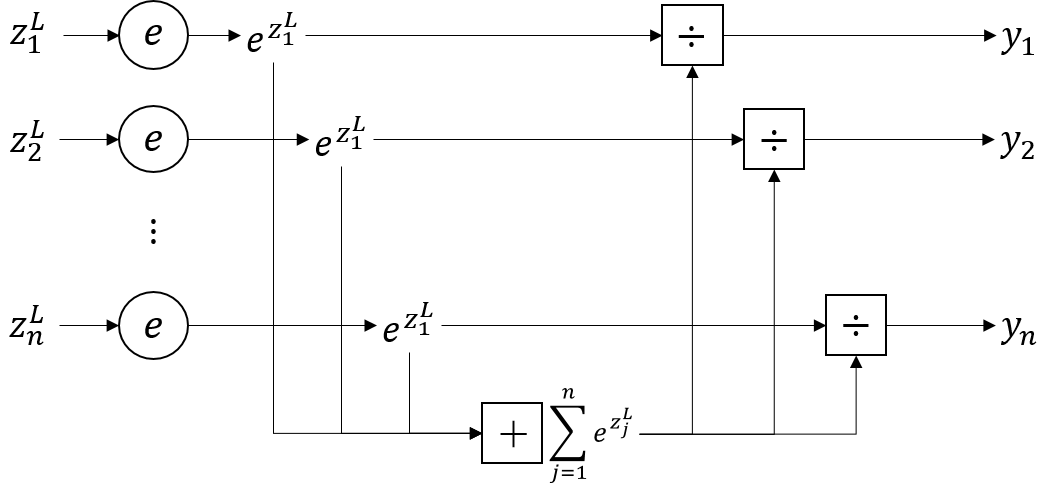

In [21]:
from IPython.display import Image
Image(filename = 'softmax.png', width=600, height=300)

In [22]:
def softmaxRegression(datasets):
    # 指定超参数
    alpha = 0.15
    n_epochs = 1000
    epsilon = 0.00001
    batch_size = 600
    L1_reg = 0.00
    L2_reg = 0.00
    
    # 随机初始化w
    input_size = 784
    output_size = 10
    rand = np.random.RandomState(int(time.time()))
    # w_initial = np.asarray(rand.normal(size=(input_size*output_size, 1))).reshape(input_size, 10)
    w_initial = np.asarray(rand.uniform(low=-np.sqrt(6. / (input_size + output_size)), 
                                        high=np.sqrt(6. / (input_size + output_size)), 
                                        size=(input_size, output_size)))
    W = [w_initial]
    
    # 构建模型
    build_model(datasets, W, alpha, n_epochs, epsilon, batch_size, L1_reg, L2_reg)

# 测试BP神经网络
1、读取数据

2、指定超参数

3、指定隐含层层数、每层神经元数目，并随机初始化$w$，构建模型

4、在训练集训练模型

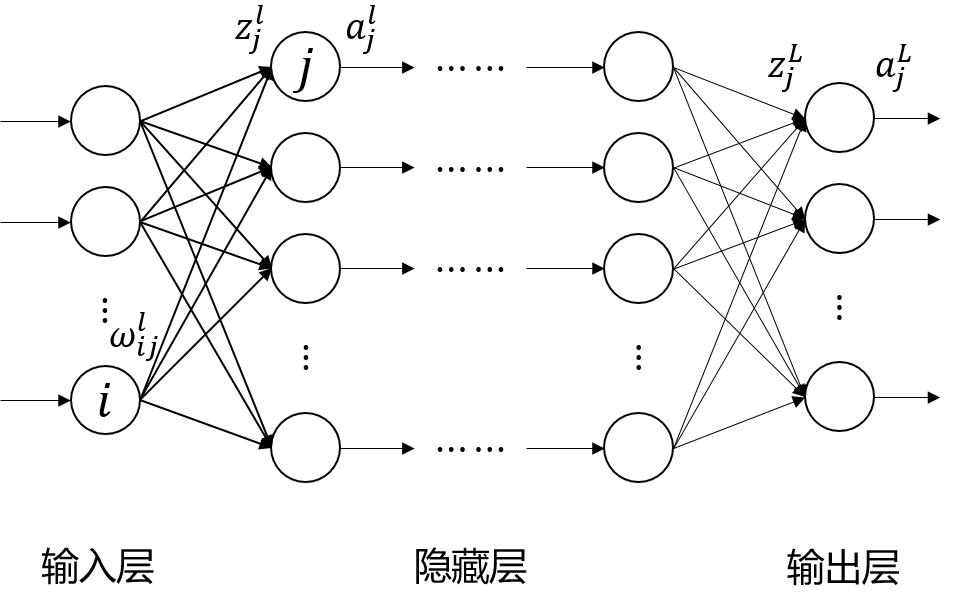

In [23]:
from IPython.display import Image
Image(filename = 'mlp.png', width=500, height=300)

在训练集上采用batch gradient descent训练模型，在验证集上验证模型性能

In [24]:
def mlp(datasets):
    # 指定超参数
    alpha = 0.01   # 步长，学习率 
    n_epochs = 1000    # epoch次数，将整个训练集迭代一遍叫一个epoch
    epsilon = 0.00001     # 梯度下降提前停止阈值
    batch_size = 10   # batch大小
    L1_reg = 0.00     # L1正则化参数
    L2_reg = 0.001   # L2正则化参数
    
    # 初始化权重w
    input_size = 784   # 输入层神经元数目
    output_size = 10    # 输出层神经元数目
    rand = np.random.RandomState(int(time.time()))
    hidden_unit = [500]   # 隐含层神经元数目
    W = hiddenLayer(input_size, output_size, hidden_unit, rand)    # 初始化连接权重
    
    # 构建模型与调优
    build_model(datasets, W, alpha, n_epochs, epsilon, batch_size, L1_reg, L2_reg)

# 代码入口

In [ ]:
import pickle, gzip
import numpy as np
import time
import timeit

if __name__ == "__main__":
    # 加载数据
    datasets = load_data()

    starttime = timeit.default_timer()     # 开始训练时间
    
    # 选择模型
    print("请选择模型类型：1、softmaxRegression；2、mlp")
    model_type = input()
    if int(model_type) == 1:
        softmaxRegression(datasets)
    elif int(model_type) == 2:
        mlp(datasets)
    else:
        print("暂时没有这类模型")
    
    endtime = timeit.default_timer()   # 结束训练时间
    print("代码运行%.2f分钟" %((endtime - starttime) / 60.))

# 显示数据集信息

In [ ]:
datasets = load_data()
train_set_x, train_set_y = datasets[0]
valid_set_x, valid_set_y = datasets[1]
test_set_x, test_set_y = datasets[2]
print(train_set_x.shape)
print(valid_set_x.shape)
print(test_set_x.shape)
print(type(train_set_x))
# train_set_x.get_value(borrow=True).shape[0]

样本以numpy数组的形式存储，且其大小为50000\*784，每一行代表一个样本，每个样本由784维（28\*28）特征表示。

# 显示图片样例
取任意一个样本，将其反归一化并转换为整型，然后采用Image将其显示。

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

datasets = load_data()

train_set_x, train_set_y = datasets[0]      
valid_set_x, valid_set_y = datasets[1]
test_set_x, test_set_y = datasets[2]

# print(train_set_x[1].shape)
image_array = train_set_x[1].reshape(28, 28) * 255
image_array = np.uint8(image_array)
# print(image_array)
print(train_set_y[1])     # 标签

image = Image.fromarray(image_array, mode="L")
# image.show()
plt.figure("Image") # 图像窗口名称
plt.imshow(image)
plt.axis('off') # 关掉坐标轴为 off
plt.show()